In [1]:
from deep_frecker import DeepFrecker, FreckerDataSet
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from fnet import MaskLoss, Conv3DStack
from torch.optim.lr_scheduler import OneCycleLR

In [9]:
file = r"C:\Users\lucyc\Desktop\freckers_data\P1.h5"
file2 = r"C:\Users\lucyc\Desktop\freckers_data\P2.h5"
dataset1 = FreckerDataSet(file_path=file)
dataset2 = FreckerDataSet(file_path=file2)

dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])

# file_base_path = r"C:\Users\lucyc\Desktop\freckers_data\New_Fix_v"
# versions = ["2", "3", "4", "5", "6"]

# datasets = [FreckerDataSet(file_base_path + v + ".h5") for v in versions]

# # 合并两个数据集
# dataset = torch.utils.data.ConcatDataset(datasets)

# dataset = FreckerDataSet(file_path=file)
dataset = torch.utils.data.Subset(dataset, range(int(len(dataset) * (9/11)), len(dataset)))


# 按照顺序分割数据集
train_size = int(0.8 * len(dataset))  # 50% 用于训练
val_size = len(dataset) - train_size  # 50% 用于验证

# 使用 Subset 分割数据集
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_dataset, _ = random_split(train_dataset, [int(0.3 * len(train_dataset)), len(train_dataset) - int(0.3 * len(train_dataset))])
val_dataset, _ = random_split(val_dataset, [int(0.3 * len(val_dataset)), len(val_dataset) - int(0.3 * len(val_dataset))])
# 随机分割
# train_dataset, val_dataset = random_split(dataset, [int(0.5 * len(dataset)), len(dataset) - int(0.5 * len(dataset))])
# print(f"合并后的数据集大小: {len(train_dataset)}")

# # 定义训练集和验证集的大小
# train_size = int(0.8 * len(dataset))  # 80% 用于训练
# val_size = len(dataset) - train_size  # 20% 用于验证

# # 使用 random_split 分割数据集
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
shuffle = True
num_workers = 1

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, persistent_workers=True)


In [13]:
model = Conv3DStack()

In [14]:
num_epochs = 60
stop_epoch = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.001,  # 最大学习率
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.4  # warmup 的比例
)
mask_loss = MaskLoss()

train_loss_record = []
eval_loss_record = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for gameboard, action_prob, value in train_loader:
        gameboard = gameboard.to(device)
        action_prob = action_prob.to(device)
        value = value.to(device)

        optimizer.zero_grad()
        p_action_prob, p_value = model(gameboard)
        # 计算双损失
        loss_img = mask_loss(p_action_prob, action_prob)
        loss_prob = F.mse_loss(p_value.view(-1), value)
        total_loss = loss_img + loss_prob
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += total_loss.item()
    
    train_loss /= len(train_loader)
    train_loss_record.append(train_loss)

    model.eval()
    eval_loss = 0.0
    with torch.no_grad():
        for gameboard, action_prob, value in val_loader:
            gameboard = gameboard.to(device)
            action_prob = action_prob.to(device)
            value = value.to(device)

            p_action_prob, p_value = model(gameboard)
            loss_img = mask_loss(p_action_prob, action_prob)
            loss_prob = F.mse_loss(p_value.view(-1), value)
            total_loss = loss_img + loss_prob
            
            eval_loss += total_loss.item()
    
    eval_loss /= len(val_loader)
    eval_loss_record.append(eval_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.8f}, Validation Loss: {eval_loss:.8f}")

    if epoch == stop_epoch:
        torch.save(model, "C:\\Users\\lucyc\\Desktop\\freckers_data\\P2_Mini.pth")



Epoch 1, Training Loss: 1.53654707, Validation Loss: 1.06735078
Epoch 2, Training Loss: 1.00231600, Validation Loss: 0.85385821
Epoch 3, Training Loss: 0.88486948, Validation Loss: 0.69623391
Epoch 4, Training Loss: 0.84722705, Validation Loss: 0.66692529
Epoch 5, Training Loss: 0.83766198, Validation Loss: 0.65162177
Epoch 6, Training Loss: 0.82220223, Validation Loss: 0.63797912
Epoch 7, Training Loss: 0.79025350, Validation Loss: 0.57385082
Epoch 8, Training Loss: 0.76185283, Validation Loss: 0.56300639
Epoch 9, Training Loss: 0.74693877, Validation Loss: 0.56421365
Epoch 10, Training Loss: 0.72903771, Validation Loss: 0.56228113
Epoch 11, Training Loss: 0.71356223, Validation Loss: 0.56126490
Epoch 12, Training Loss: 0.69922015, Validation Loss: 0.56575599
Epoch 13, Training Loss: 0.69167034, Validation Loss: 0.56028013
Epoch 14, Training Loss: 0.67972541, Validation Loss: 0.55950528
Epoch 15, Training Loss: 0.66520118, Validation Loss: 0.56761660
Epoch 16, Training Loss: 0.6615196

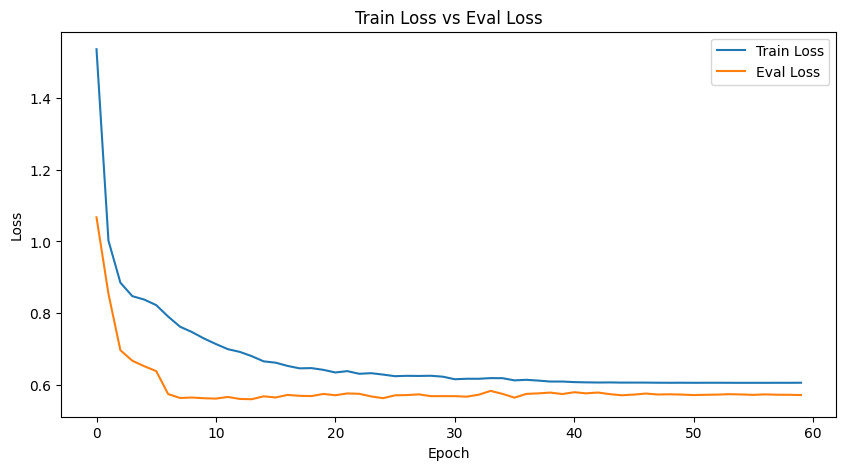

In [15]:
import matplotlib.pyplot as plt

# 绘制训练损失和验证损失的对比图
plt.figure(figsize=(10, 5))
plt.plot(train_loss_record, label='Train Loss')
plt.plot(eval_loss_record, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Eval Loss')
plt.legend()
plt.show()


In [18]:
import torch
from fnet import MaskLoss, Conv3DStack
model = torch.load("C:\\Users\\lucyc\\Desktop\\freckers_data\\P2_Mini.pth", weights_only=False)
model2 = torch.load("C:\\Users\\lucyc\\Desktop\\freckers_data\\P1_Mini.pth", weights_only=False)
#model2 = Conv3DStack()

In [20]:
from mcts import mcts_data_collect, mcts_competition
class MctsConfig:
    def __init__(self) -> None:
        self.c = 1.5
        self.t = 1
        self.finish = False
        self.visulze = False
        self.small = 0.0000001

        self.dirichlet_alpha = 0.03
        self.dirichlet_epsilon = 0.25

#res1 = mcts_competition(model, 1, r"C:\Users\lucyc\Desktop\freckers_data\temp.h5", MctsConfig(), 3, 150, model2)
print(mcts_competition(model2, 1, r"C:\Users\lucyc\Desktop\freckers_data\temp.h5", MctsConfig(), 3, 150, model, visulze=True))
print(mcts_competition(model2, 1, r"C:\Users\lucyc\Desktop\freckers_data\temp.h5", MctsConfig(), 3, 150, model, visulze=False))

线程 1 第 0 轮游戏  第 0 步 模拟进行中

Rounds:  1
🟢🔴🔴🔴🔴🔴🔴🟢
⚪🟢🟢🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🟢🟢🟢🟢⚪
🔵⚪🔵🔵🔵🔵🔵🟢
move action:  (7, 1, 7, 0, False)
线程 1 第 0 轮游戏  第 1 步 模拟进行中

Rounds:  2
🔴🔴⚪🔴🔴🔴🔴🟢
⚪🟢🟢🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🟢🟢🟢🟢⚪
🔵⚪🔵🔵🔵🔵🔵🟢
move action:  (0, 2, 0, 0, False)
线程 1 第 0 轮游戏  第 2 步 模拟进行中

Rounds:  3
🔴🔴⚪🔴🔴🔴🔴🟢
⚪🟢🟢🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🟢⚪
🔵⚪🔵🔵⚪🔵🔵🟢
move action:  (7, 4, 6, 3, False)
线程 1 第 0 轮游戏  第 3 步 模拟进行中

Rounds:  4
🔴⚪⚪🔴🔴🔴🔴🟢
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🟢⚪
🔵⚪🔵🔵⚪🔵🔵🟢
move action:  (0, 1, 1, 2, False)
线程 1 第 0 轮游戏  第 4 步 模拟进行中

Rounds:  5
🔴⚪⚪🔴🔴🔴🔴🟢
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🔵⚪
🔵⚪🔵🔵⚪⚪🔵🟢
move action:  (7, 5, 6, 6, False)
线程 1 第 0 轮游戏  第 5 步 模拟进行中

Rounds:  6
🔴⚪⚪🔴🔴⚪🔴🔴
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🔵⚪
🔵⚪🔵🔵⚪⚪🔵🟢
move action:  (0, 5, 0, 7, False)
线程 1 第 0 轮游戏  第 6 步 模拟进行中

Rounds:  7
🔴⚪⚪🔴🔴⚪🔴🔴
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🔵🟢🔵⚪
🔵⚪🔵⚪⚪⚪🔵🟢
move action:  (7, 3, 6, 4,

KeyboardInterrupt: 

In [ ]:
import threading
import time
from mcts import mcts_data_collect

#(model, thread_num, file, rounds=100, sim_step=300)
# 创建多个线程
threads = []
for i in range(8):
    thread = threading.Thread(target=mcts_data_collect, 
            args=(model, i+1, f"C:\\Users\\lucyc\\Desktop\\freckers_data\\batch_1.h5", 30, 500))
    threads.append(thread)
    thread.start()

# 等待所有线程完成
for thread in threads:
    thread.join()


In [12]:
torch.save(model, "C:\\Users\\lucyc\\Desktop\\freckers_data\\batch_2_no_inverse.pth")